#Modelo Garch para calculo de VaR de un activo financiero

### ¿Qué son los modelos GARCH?

Los modelos GARCH (Generalized Autoregressive Conditional Heteroskedasticity) provienen de la familia de modelos ARCH que se utilizan para describir cómo la volatilidad de una serie de tiempo cambia con el tiempo.

El modelo GARCH en específico utiliza los errores pasados al cuadrado (ARCH) y la varianza pasada (GARCH).

El modelo es el siguiente:

\begin{aligned}
r_t &= \mu + \varepsilon_t \\
\varepsilon_t &= \sigma_t z_t, \quad z_t \sim \text{N}(0,1) \\
\sigma_t^2 &= \omega + \sum_{i=1}^p \alpha_i \varepsilon_{t-i}^2 + \sum_{j=1}^q \beta_j \sigma_{t-j}^2
\end{aligned}

Donde:

\begin{aligned}
\mu &\quad \text{: media del retorno} \\
\varepsilon_t &\quad \text{: residuo en el tiempo } t \\
\sigma_t^2 &\quad \text{: varianza condicional (volatilidad al cuadrado)} \\
z_t &\quad \text{: shock aleatorio con media 0 y varianza 1} \\
\omega &\quad \text{: constante positiva} \\
\alpha_i &\quad \text{: impacto de los errores pasados (ARCH)} \\
\beta_j &\quad \text{: persistencia de la volatilidad (GARCH)}
\end{aligned}


### ¿Qué es el VaR?

El VaR (Value at Risk) es un modelo que mide cuánto podrías perder con cierto nivel de confianza en determinado tiempo. Su fórmula es:

\begin{aligned}
VaR_{t+1} = \mu_{t+1} + \sigma_{t+1}z_\alpha
\end{aligned}

Donde:

\begin{aligned}
\mu_{t+1} &\quad \text{: media del retorno en el tiempo t+1} \\
\sigma_{t+1} &\quad \text{: varianza condicional esperada en el tiempo t+1} \\
z_\alpha &\quad \text{: Cuantil de la distribución al nivel } \alpha \\
\end{aligned}

### Utilización del modelo GARCH en el cálculo de un VaR

La razón por la cual utilizaremos el modelo GARCH para el cálculo de un VaR es porque el modelo GARCH nos puede dar una estimación de la varianza considerando que esta no es constante en el tiempo. Después de esto, compararemos los resultados del modelo GARCH contra el VaR no paramétrico.


## Ejecución

In [19]:
# Cargamos librerias
!pip install arch
import numpy as np
import pandas as pd
from arch import arch_model
from scipy.stats import norm
from scipy.stats import chi2
import matplotlib.pyplot as plt


In [32]:

# Cargamos los datos de la acción y calculamos los rendimientos.
data = pd.read_csv('/content/drive/MyDrive/RyST/precios_APPLE.csv')
returns = 100*data['AAPL.MX.Close'].pct_change().dropna()

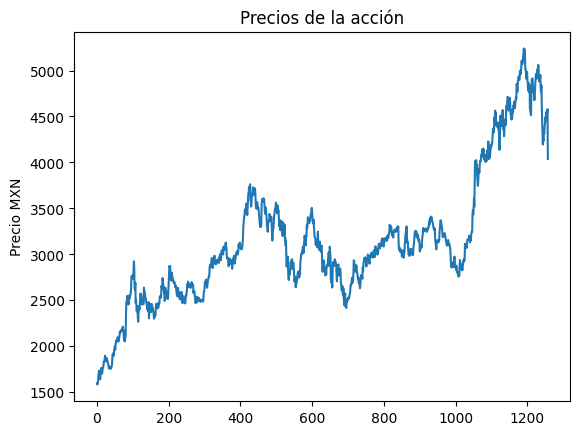

In [33]:
#Graficamos los precios de la acción.
plt.title("Precios de la acción")
plt.ylabel("Precio MXN")
plt.plot(data['AAPL.MX.Close'])
plt.show()

Analisando los precios vemos que hay una volatilidad variable en el tiempo. Se identifican episodios de alta volatilidad, contrastando con periodos de baja volatilidad, donde la dispersión de los precios es significativamente menor. Esta observación de periodos de volatilidad nos daria una buena razon para usar un modelo GARCH.

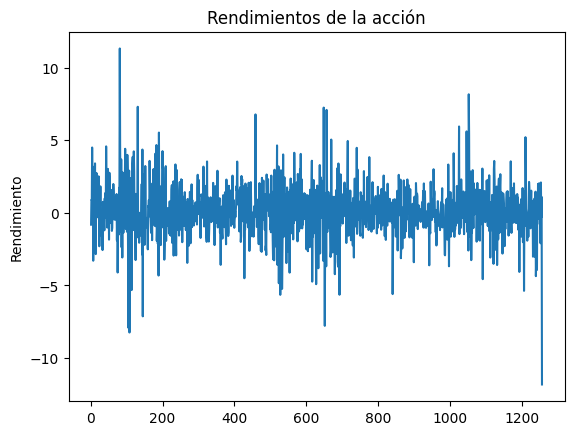

In [34]:
#Graficamos los rendimientos
plt.title("Rendimientos de la acción")
plt.ylabel("Rendimiento")
plt.plot(returns)
plt.show()

El gráfico de los rendimientos corrobora los intervalos de elevada varianza, donde la dispersión de los rendimientos es considerable, alternándose con periodos de baja varianza, en los que los rendimientos presentan una menor dispersión. Esto refuerza que la volatilidad de los rendimientos no es constante a lo largo del tiempo, sino que hay periodos de alta y baja volatilidad.

In [35]:
#Ajustamos el modelo GARCH(1,1)
model = arch_model(returns, vol='Garch', p=1, q=1, dist='normal')
res = model.fit(disp='off')
miu = res.params['mu']


In [36]:
#Calculamos la volatilidad condicional estimada por GARCH.
expected_volatility = np.sqrt(res.conditional_volatility)

In [37]:
#Estimamos la volatilidad para los próximos 30 días.
forecast = res.forecast(horizon=30)
future_volatility = np.sqrt(forecast.variance.values[-1, :])


In [38]:
#Calculamos el VaR al 95% (percentil 5%) con el modelo GARCH.
z_95 = norm.ppf(0.05)
VaR_95 = miu + (z_95 * future_volatility[1])
VaR_95

np.float64(-4.932703045741584)

In [39]:
#Calculamos el VaR no parametrico
VaR_p_95 = np.mean(returns) + np.percentile(returns, 5)
VaR_p_95

np.float64(-2.6522447478596307)

Comparando los dos cálculos de VaR, notamos que el modelo GARCH estima una posible pérdida más grande que el método no parámetrico. Sin embargo, para analizar mejor cómo se comportan ambos modelos y hacer una comparación más sólida, vamos a calcular el VaR de cada uno usando todos nuestros datos históricos. Así, podremos ver qué modelo se ajusta mejor a los cambios que ocurren en los mercados con el tiempo.


In [40]:
#Calculamos los VaR no parametrico y de GARCH utilizando los valores historicos a 500 dias de nuestra accion para compararlos
VaR_p_95 = []
VaR_95 = []
return_real = []
for i in range(500,len(returns)-1):
  returns_aux = returns[i-500:i]
  return_real.append(returns[i+1])
  VaR_p_95.append(np.mean(returns_aux) + np.percentile(returns_aux, 5))
  model = arch_model(returns_aux, vol='Garch', p=1, q=1, dist='normal')
  res = model.fit(disp='off')
  miu = res.params['mu']
  forecast = res.forecast(horizon=2)
  future_volatility = np.sqrt(forecast.variance.values[-1, :])
  VaR_95.append(miu + (z_95 * future_volatility[1]))

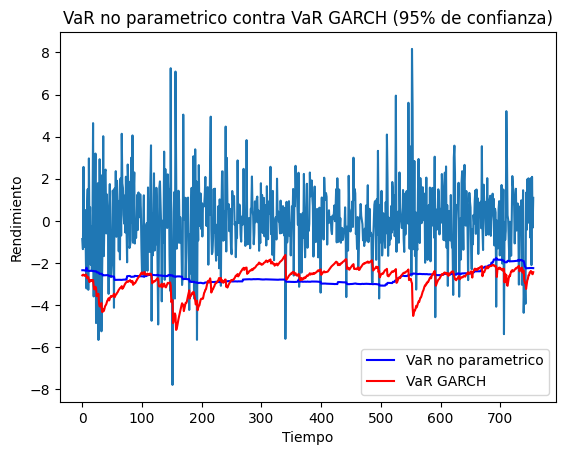

In [41]:
plt.plot(return_real)
plt.plot(VaR_p_95, label="VaR no parametrico", color="blue")
plt.plot(VaR_95, label="VaR GARCH", color="red")
plt.title("VaR no parametrico contra VaR GARCH (95% de confianza)")
plt.xlabel("Tiempo")
plt.ylabel("Rendimiento")
# Mostrar leyenda
plt.legend()
# Mostrar la gráfica
plt.show()

In [42]:
#Calculamos cuantos veces hubo perdidas mayores que el VaR
fallas_VaR_GARCH = 0
fallas_VaR_p = 0
for i in range(len(VaR_95)):
  if VaR_95[i] > return_real[i]:
    fallas_VaR_GARCH += 1
  if VaR_p_95[i] > return_real[i]:
    fallas_VaR_p += 1
print(fallas_VaR_GARCH/len(VaR_95))
print(fallas_VaR_p/len(VaR_p_95))

0.051587301587301584
0.06481481481481481


In [51]:
#Utilizamos la prueba de Kupiec para tener una prueba de hipotesis sobre los fallos de ambos modelos
def kupiec_test(x, T, p=0.05):
    if x == 0 or x == T:
        return None, None
    p_hat = x / T
    term1 = (1 - p)**(T - x) * (p)**x
    term2 = (1 - p_hat)**(T - x) * (p_hat)**x
    LR_uc = -2 * np.log(term1 / term2)
    p_value = 1 - chi2.cdf(LR_uc, df=1)

    return LR_uc, p_value

prueba_kupiec_GARCH = kupiec_test(fallas_VaR_GARCH, len(VaR_95))
prueba_kupiec_p = kupiec_test(fallas_VaR_p, len(VaR_p_95))

In [52]:
print(prueba_kupiec_GARCH)
print(prueba_kupiec_p)



(np.float64(0.03970452347288402), np.float64(0.8420594144410161))
(np.float64(3.207671081429086), np.float64(0.07329373935143191))


##Conclusión

Al comparar el modelo no paramétrico con el modelo GARCH, se observa que el primero exhibe una respuesta lineal, sin incorporar las variaciones en la volatilidad a lo largo del tiempo. En contraste, el modelo GARCH demuestra una capacidad de adaptación a estos periodos de alta y baja volatilidad, proporcionando una estimación del riesgo que refleja mejor las condiciones cambiantes del mercado.

Esta diferencia se evidencia al examinar la frecuencia con la que las pérdidas reales superan el VaR estimado (con un nivel de confianza del 95%). El modelo GARCH arrojó una tasa de excedencia del 5%, consistente con el nivel de confianza establecido. Por otro lado, el modelo no paramétrico presentó una tasa de excedencia del 6.4%, superando el 5% esperado. Este resultado sugiere que el modelo GARCH ofrece una calibración más precisa del riesgo en comparación con el modelo no paramétrico.

Al realizar las pruebas de hipotesis de Kupiec, donde $H_0: p=p_0$ vs $H_1: p \neq p_0$, con $p=0.05$ y $p_0$ nuestro valor observado, tenemos los siguientes resultados:

- Modelo GARCH: El valor p del modelo GARCH es de 0.8, por lo cual claramente rechazamos $H_0$, lo que nos dice que el modelo esta muy bien calibrado

- Modelo no parametrico: El valor p del modelo no parametrico es de 0.07, que si bien es mayor que 0.05, sigue estando cerca del umbral, por lo que formalmente no rechazamos $H_0$